In [13]:
# header files
import matplotlib.pyplot as plt
import numpy as np
import math

# Reading the real data into numpy dataframe
dataset = np.genfromtxt(r"datasets\2_music.txt",delimiter=',')
X_dataset = dataset[:,0:68] 
Y_dataset = dataset[:,68:70]
x_train = X_dataset[:math.floor(0.7*len(X_dataset))]
y_train = Y_dataset[:math.floor(0.7*len(X_dataset))]
x_valid = X_dataset[math.floor(0.7*len(X_dataset)):math.floor(0.8*len(X_dataset))]
y_valid = Y_dataset[math.floor(0.7*len(X_dataset)):math.floor(0.8*len(X_dataset))]
x_test = X_dataset[math.floor(0.8*len(X_dataset)):len(X_dataset)]
y_test = Y_dataset[math.floor(0.8*len(X_dataset)):len(X_dataset)]

# total number of features
degree = len(X_dataset[0])

In [2]:
# generates the gaussian basis function for the training data and the centers of the clusters 
# input : training data features, cluster centre features, sigma square (variance of the features), no. of clusters
def gaussian_Basis(x_train,mean,sigma_square,k):
    Phi = np.zeros((len(x_train),k))
    for i in range(len(x_train)):
        for j in range(k):
            for l in range(degree):
                Phi[i][j] += (x_train[i][l]-mean[j][l])**2
    return math.e**(Phi*(-1)/sigma_square)

In [3]:
# generates the Phi_tilde matrix required during Tikhonov regularization
# inputs : cluster centres, variance of the features, no. of clusters, no. of features
def generatePhi_tilde(mean,sigma_square,k):    
    Phi_tilde = np.zeros((k,k))
    for i in range(k):
        for j in range(k):
            for l in range(degree):
                Phi_tilde[i][j] += (mean[i][l]-mean[j][l])**2
    return math.e**(Phi_tilde*(-1)/sigma_square)

In [10]:
# returns the ERMS for the train, valid and test data using gaussian basis function to predict the function output
# training data features, training data target output, regularization coefficient, cluster centres, variance, no. of clusters 
def erms_error_gaussian(x_train,y_train,lamda,mean,sigma_square,k):
    Phi = gaussian_Basis(x_train,mean,sigma_square,k)
    I = generatePhi_tilde(mean,sigma_square,k)
    w = np.linalg.inv(Phi.transpose().dot(Phi)+lamda*I).dot(Phi.transpose().dot(y_train))

    # generate the model output for training data
    print("\nScatter plot of train data for "+str(k)+" clusters of gaussian basis function")
    predicted = Phi.dot(w)
    plt.scatter(y_train[:,0], predicted[:,0])
    plt.xlabel("Target output")
    plt.ylabel("Predicted output")
    plt.show()
    plt.scatter(y_train[:,1], predicted[:,1])
    plt.xlabel("Target output")
    plt.ylabel("Predicted output")
    plt.show()

    error_train = 0
    for i in range(len(y_train)):
        error_train += (predicted[i]-y_train[i])**2

    error_train /= len(y_train)

    # generate the model output for training data
    Phi = gaussian_Basis(x_valid,mean,sigma_square,k)
    predicted = Phi.dot(w)
    
    error_valid = 0
    for i in range(len(y_valid)):
        error_valid += (predicted[i]-y_valid[i])**2

    error_valid /= len(y_valid)

    # generate the model output for test data
    print("\nScatter plot of test data for "+str(k)+" clusters of gaussian basis function")
    Phi = gaussian_Basis(x_test,mean,sigma_square,k)
    predicted = Phi.dot(w)
    plt.scatter(y_test[:,0], predicted[:,0],color="red")
    plt.xlabel("Target output")
    plt.ylabel("Predicted output")
    plt.show()
    plt.scatter(y_test[:,1], predicted[:,1],color="red")
    plt.xlabel("Target output")
    plt.ylabel("Predicted output")
    plt.show()

    error_test = 0
    for i in range(len(y_test)):
        error_test += (predicted[i]-y_test[i])**2

    error_test /= len(y_test)
    return math.sqrt(sum(error_train)),math.sqrt(sum(error_valid)),math.sqrt(sum(error_test))

In [5]:
# returns the euclidian distance between 2 points 
# inputs : takes 2 points
def Euclidean_distance(data1,data2):
    return math.sqrt(sum((data1-data2)**2))

In [6]:
# assign a training example to a cluster depending upon the euclidean distance from the cluster centre
# inputs : cluster centres, training example, no. of clusters
def assignCluster(mean,data,k):
    z = np.zeros((len(data),k))
    for i in range(len(data)):
        closest = Euclidean_distance(data[i],mean[0])**2
        z[i][0] = 1
        for j in range(len(mean)):
            dist = Euclidean_distance(data[i],mean[j])**2
            if(dist < closest):
                closest = dist
                z[i] = np.zeros(k)
                z[i][j] = 1
    return z

In [7]:
# update the mean of the clusters
# inputs : cluster assignment, train data, no. of clusters
def updateMean(z,data,k):
    mean = np.zeros((k,degree))
    N = sum(z)
    for i in range(k):
        for j in range(len(data)):
            mean[i]+=data[j]*z[j][i]
        mean[i]/=N[i]
    return mean

In [8]:
# K means clustering to find k clusters
# inputs : no. of clusters, train data, max no. of iterations
def KmeansClustering(k,data,iteration):
    mean = np.zeros((k,degree))

    # random initialization
    mean_index_initial = np.random.choice(len(data),k)
    mean = data[mean_index_initial]
    z_old = assignCluster(mean,data,k)

    # updating the mean and assigning the clusters again
    for i in range(iteration):
        mean = updateMean(z_old,data,k)
        z_new = assignCluster(mean,data,k)
        if np.allclose(z_new,z_old):
            return mean
        z_old = z_new
    return mean


Scatter plot of train data for 25 clusters of gaussian basis function


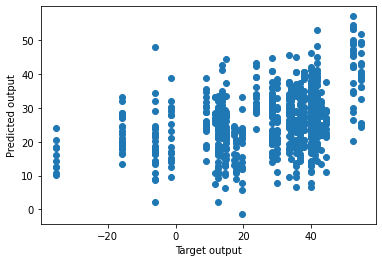

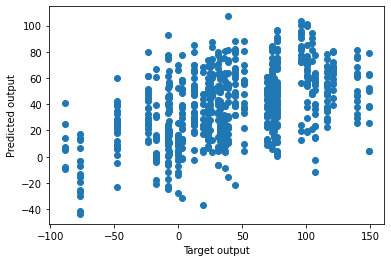


Scatter plot of test data for 25 clusters of gaussian basis function


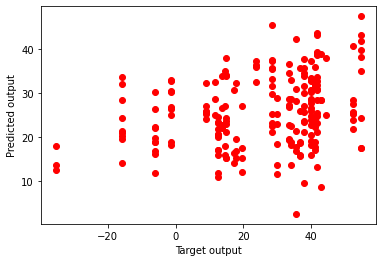

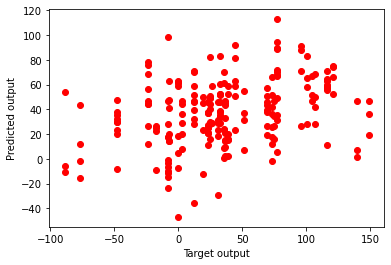

ERMS of training data : {0} 48.16365668659747
45.555450099601664
51.881203235230096


In [14]:
# variance in the features 
sigma_square = 100

# number of clusters
k = 25

# maximum number of iterations while finding K means clusters
iteration = 100

# means obtained using K means clustering algorithm
mean = KmeansClustering(k,x_train,iteration)

# regularisation coefficient
lamda = 0

# error between predicted and actual values of the target feature
error_train,error_valid,error_test = erms_error_gaussian(x_train,y_train,lamda,mean,sigma_square,k)

In [15]:
print("ERMS of training data : ",error_train)
print("ERMS of validation data : ",error_valid)
print("ERMS of test data : ",error_test)

ERMS of training data :  48.16365668659747
ERMS of validation data :  45.555450099601664
ERMS of test data :  51.881203235230096
